# Ad analysis

**Analysis answers:**
- Count the number of all events by day, the number of impressions, the number of clicks, the number of unique ads and unique campaigns.
- Figure out why there was such a jump on 2019-04-05? Which events have increased? Do all the ads or just some of them?
- Find the top 10 ads by CTR for all time.
- It seems that there is a bug in our logs, ads come with clicks, but without impressions. How many such ads are there, are there any patterns? Is this problem seen on all platforms?
- Are there any differences in CTR between ads with and without video? And what is the 95th percentile CTR for all ads for 2019-04-04?
- On which day did we earn the most? Which one is smaller? We charge customers money if a CPC ad is clicked, and we charge money for each CPM ad display. If a CPM ad has a price of 200 rubles, then we earn 200/1000 rubles per display.
- Which is the most popular platform for placing advertisements? How many percent of impressions are on each of the platforms (the platform column)?

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [75]:
ads_data = pd.read_csv('../../../data/01_module/05_part/lesson_5_ads_data.csv.zip', compression='zip')

In [76]:
ads_data['full_date'] = pd.to_datetime(ads_data.time, unit='s')

In [77]:
ads_data['date'] = pd.to_datetime(ads_data['date'])

In [78]:
ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793,2019-04-01 00:00:48
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041,2019-04-01 16:24:26
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41,2019-04-01 16:24:26
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898,2019-04-01 16:24:26
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29,2019-04-01 16:24:26


In [79]:
r, c = ads_data.shape
print(f'Rows: {r}, columns: {c}')
ads_data.info()

Rows: 3176714, columns: 13
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3176714 entries, 0 to 3176713
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ad_id                  int64         
 1   time                   int64         
 2   event                  object        
 3   date                   datetime64[ns]
 4   ad_cost_type           object        
 5   has_video              int64         
 6   client_union_id        int64         
 7   campaign_union_id      int64         
 8   platform               object        
 9   ad_cost                float64       
 10  target_audience_count  int64         
 11  user_id                int64         
 12  full_date              datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(7), object(3)
memory usage: 315.1+ MB


Count the number of all events by day, the number of impressions, the number of clicks, the number of unique ads and unique campaigns.

<Axes: xlabel='date'>

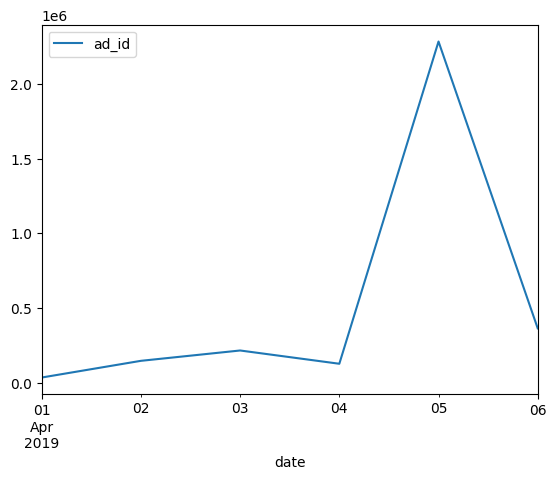

In [80]:
ads_data.groupby('date').agg({
    'ad_id': 'count'
}).plot()

In [81]:
ads_data.groupby(['date', 'event'], as_index=False) \
    .agg({'ad_id': 'count'}) \
    .pivot(index='date', columns='event', values='ad_id') \
    .reset_index()

event,date,click,view
0,2019-04-01,735,34832
1,2019-04-02,1518,145811
2,2019-04-03,1678,214851
3,2019-04-04,1517,126182
4,2019-04-05,501595,1783288
5,2019-04-06,80420,284287


In [82]:
ads_data.groupby(['date'], as_index=False) \
    .agg({
        'campaign_union_id': pd.Series.nunique,
        'ad_id': pd.Series.nunique
    }) \
    .rename(columns={
        'campaign_union_id': 'number_of_campaigns',
        'ad_id': 'number_of_ads'
    })

,date,number_of_campaigns,number_of_ads
0,2019-04-01,49,49
1,2019-04-02,146,146
2,2019-04-03,177,179
3,2019-04-04,147,150
4,2019-04-05,130,131
5,2019-04-06,60,61


Figure out why there was such a jump on 2019-04-05? Which events have increased? Do all the ads or just some of them?

In [83]:
ads_data[ads_data.date == '2019-04-05'] \
    .groupby('ad_id') \
    .agg({'time': 'count'}) \
    .sort_values(by='time', ascending=False) \
    .head()

,time
ad_id,
112583,2166611
29927,27186
44635,8268
46583,7327
44956,5656


In [84]:
ad_id = 112583

In [85]:
ads_data.query('ad_id == @ad_id') \
    .groupby(['date', 'event'], as_index=False) \
    .agg({'ad_id': 'count'})

,date,event,ad_id
0,2019-04-05,click,500207
1,2019-04-05,view,1666404
2,2019-04-06,click,80229
3,2019-04-06,view,268384


Find the top 10 ads by CTR for all time.

In [86]:
ads_data_by_ad = ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='ad_id', columns='event', values='time') \
    .reset_index()

In [88]:
ads_data_by_ad = ads_data_by_ad.assign(ctr=ads_data_by_ad.click / ads_data_by_ad.view,
                           ctr_per=ads_data_by_ad.click / ads_data_by_ad.view * 100)

In [89]:
ads_data_by_ad.sort_values(by='ctr', ascending=False).head(10)

event,ad_id,click,view,ctr,ctr_per
289,112583,580436.0,1934788.0,0.300000,29.999979
324,119450,258.0,1254.0,0.205742,20.574163
125,38575,43.0,257.0,0.167315,16.731518
144,40968,29.0,217.0,0.133641,13.364055
207,45642,42.0,344.0,0.122093,12.209302
283,110924,11.0,95.0,0.115789,11.578947
194,45043,28.0,245.0,0.114286,11.428571
96,35034,112.0,997.0,0.112337,11.233701
5,4585,53.0,476.0,0.111345,11.134454
328,120347,236.0,2168.0,0.108856,10.885609


In [90]:
ads_data_by_ad.ctr.mean()

np.float64(0.020628096080757954)

In [91]:
ads_data_by_ad.ctr.median()

np.float64(0.010753240746688594)

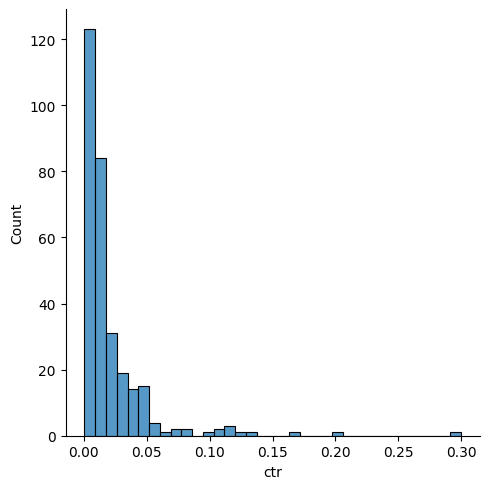

In [92]:
sns.displot(ads_data_by_ad.ctr, kde=False)

 It seems that there is a bug in our logs, ads come with clicks, but without impressions. How many such ads are there, are there any patterns? Is this problem seen on all platforms?

In [93]:
ads_data_by_ad = ads_data_by_ad.fillna(0)

In [95]:
ads_ids_bug = ads_data_by_ad.query('click == 0').ad_id

In [100]:
ads_data[ads_data.ad_id.isin(ads_ids_bug)] \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .sort_values(by='ad_id', ascending=False)

,platform,ad_id
0,android,4906
1,ios,3075
2,web,1988


In [101]:
ads_data \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .sort_values(by='ad_id', ascending=False)

,platform,ad_id
0,android,1588211
1,ios,953078
2,web,635425


Are there any differences in CTR between ads with and without video? And what is the 95th percentile CTR for all ads for 2019-04-04?

In [137]:
df_2019_04_04 = ads_data[ads_data.date == '2019-04-04'].groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='ad_id', columns='event', values='time') \
    .reset_index() \
    .fillna(0)

In [109]:
df_2019_04_04['ctr'] = df_2019_04_04['click'] / df_2019_04_04['view']

In [114]:
df_2019_04_04[df_2019_04_04['click'] > 0].ctr.quantile(q=.95)

np.float64(0.10211538461538454)

In [152]:
df_by_video = ads_data.groupby(['has_video', 'event'], as_index=False) \
    .agg({'ad_id': 'count'}) \
    .pivot(index='has_video', columns='event', values='ad_id')

df_by_video = df_by_video.assign(ctr=df_by_video['click'] / df_by_video['view'] )

In [153]:
df_by_video

event,click,view,ctr
has_video,,,
0,587437,2582113,0.227502
1,26,7138,0.003642


On which day did we earn the most? Which one is smaller? We charge customers money if a CPC ad is clicked, and we charge money for each CPM ad display. If a CPM ad has a price of 200 rubles, then we earn 200/1000 rubles per display.

In [161]:
ads_data[(ads_data.ad_cost_type == 'CPC') & (ads_data.event == 'click')].ad_cost.sum()

np.float64(84810.0)

In [162]:
ads_data[(ads_data.ad_cost_type == 'CPM') & (ads_data.event == 'view')].ad_cost.sum() / 1000

np.float64(497090.67780000006)

In [181]:
df_by_date = ads_data.groupby(['date', 'ad_cost_type', 'event'], as_index=False) \
    .agg({'ad_id': 'count', 'ad_cost': 'sum'})


def get_total(row):
    if row.ad_cost_type == 'CPC' and row.event == 'click':
        return row.ad_cost
    if row.ad_cost_type == 'CPM' and row.event == 'view':
        return row.ad_cost / 1000
    return 0
    
df_by_date['total'] = df_by_date.apply(get_total, axis=1)

In [186]:
df_by_date.groupby('date') \
    .agg({'total': 'sum'}) \
    .sort_values(by='total', ascending=False)

,total
date,
2019-04-05,358559.7490
2019-04-03,73209.5170
2019-04-06,56840.3376
2019-04-04,46294.3568
2019-04-02,33837.0051
2019-04-01,13159.7123


In [171]:
ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'min'}) \
    .pivot(index='ad_id', columns='event', values='time') \
    .query('click < view')

event,click,view
ad_id,,
16548,1.554336e+09,1.554336e+09
30939,1.554165e+09,1.554173e+09
40464,1.554164e+09,1.554164e+09
42007,1.554423e+09,1.554423e+09
44543,1.554336e+09,1.554337e+09
45436,1.554336e+09,1.554336e+09
119450,1.554336e+09,1.554336e+09


In [175]:
ads_data[ads_data.ad_id == 16548].sort_values(by='time').head(3)

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
512690,16548,1554336083,click,2019-04-04,CPM,0,722,16523,ios,196.6,53199,4133,2019-04-04 00:01:23
511482,16548,1554336278,view,2019-04-04,CPM,0,722,16523,android,196.6,53199,3736,2019-04-04 00:04:38
511438,16548,1554336352,view,2019-04-04,CPM,0,722,16523,ios,196.6,53199,4206,2019-04-04 00:05:52
